# PINN for a 1-D BVP

For given constants $\mathrm{P_e}, \mathrm{D_a}$, consider 

In this assignment, you will use feed-forward networks to solve the nonlinear diffusion-advection-reaction equation

$$
Lu := u'' - \mathrm{P_e} u' + \mathrm{D_a} u (1-u) = 0, \qquad x \in (0,1)
$$

with boundary condition

$$
u(0) = 0, \qquad u(1) = 1
$$

In this equation, the non-dimensional number Pe is the Peclet number; it measures the strength of advection
relative to diffusion. Da is the Damkohler number, which measures the strength of reaction to diffusion.

(1) Write a function that creates a feed-forward network of width=20, depth=5 with input and output dimensions 1. This will be used to approximate the solution
$$
u(x) \approx u(x; θ)
$$
The weights and biases $(θ)$ should be initialized using `RandomNormal` distribution. All hidden layers should make use of a `sine` activation function, `tf.math.sin` while no activation should be used in the output layer. Use l2 regularization in all layers with a parameter 1.0e-7.

(2) Create an array of $N = 100$ uniformly spaced points in $[0, 1]$. Train a neural network with the following loss function
$$
\Pi(\theta) = \frac{1}{N} \sum_{i=1}^N (Lu(x_i;\theta))^2 
              + \lambda_b \left[ u^2(0; \theta) + (u(1; \theta) - 1)^2 \right]
$$
which is the sum of the interior residual and a scaled boundary residual. Use $\lambda_b = 10$ for the training.  Consider four different sets of values for the non-dimensional parameters:
  * Pe = 0.1, Da = 0.1 (diffusion dominates).
  * Pe = 10, Da = 0.1 (advection dominates).
  * Pe = 0.1, Da = 10 (reaction dominates).
  * Pe = 10, Da = 10 (advection and reaction dominate).

(3) For each of the four parameter values, try three different initializations, and train the network for 8,000 epochs. Save the history of the interior loss, boundary loss, total loss, and the final predicted solution in arrays/lists. Out of these select the one that has smallest final total loss as the “best” network for each set of parameter values.

(4) For each set of parameter values generate a plot of the interior, boundary and total loss as a function of epoch for the “best” network. Create another plot of the predicted solution and the benchmark solution provided to you. Which set(s) of parameter values does not yield a satisfactory solution?

(5) For the set(s) of parameter values that do not yield a satisfactory solution, repeat the previous step with $\lambda_b = 1000$. What do you observe?

(6) If you wanted to improve the accuracy of your solution, what would you do?

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
fsize = 15
plt.rcParams.update({'font.size': fsize})

## Neural network

In [2]:
def MLP(Input_Dim=1,Output_Dim=1,Width=20,Depth=10,reg_param=1.0e-7):

    Reg_Func      = keras.regularizers.l2
    Reg_Param     = reg_param
    Act_Func      = tf.math.sin

    assert Depth > 1, 'Depth of generator must be greater than 1'
    
    model = tf.keras.Sequential()
    
    model.add(keras.layers.Dense(Width, 
                                 input_shape=(Input_Dim,), 
                                 activation=Act_Func,
                                 kernel_initializer='RandomNormal', 
                                 bias_initializer='RandomNormal',
                                 kernel_regularizer=Reg_Func(Reg_Param)))

    # Adding remaining hidden layers
    if(Depth > 2):
        for l in range(Depth - 2):
            #model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Dense(Width, 
                                         activation=Act_Func,
                                         kernel_initializer='RandomNormal', 
                                         bias_initializer='RandomNormal',
                                         kernel_regularizer=Reg_Func(Reg_Param)))
            
    # Adding output layer
    model.add(keras.layers.Dense(Output_Dim, 
                                 activation=None,
                                 kernel_initializer='RandomNormal', 
                                 bias_initializer='RandomNormal',
                                 kernel_regularizer=Reg_Func(Reg_Param)))

    return model

## Loss function

This function computes $\Pi(\theta)$.

In [3]:
# Define custom loss function
def pde_loss(x,model,Pe,Da):
    with tf.GradientTape() as t1:
        t1.watch(x)
        with tf.GradientTape() as t2:
            t2.watch(x)
            u  = model(x)
            loss_int = Da*u*(1.0-u)
            loss_bnd = u[0,0]**2 + (u[-1,0]-1.0)**2
        dudx = t2.gradient(u,x)
    du2dx2 = t1.gradient(dudx,x) 
    loss_int += du2dx2 - Pe*dudx
    loss_int = tf.reduce_mean(tf.square(loss_int))   

    return loss_int, loss_bnd

## Train PINN

The next function trains the neural network for given values of Pe, Da, i.e., it finds the network parameters $\theta$ by minimizing the loss function.

In [4]:
def train_pinn(x,Pe,Da,lb,max_epoch):
    int_loss_loc = np.zeros(max_epoch)
    bnd_loss_loc = np.zeros(max_epoch)
    loss_loc = np.zeros(max_epoch)

    tf.keras.backend.clear_session()
    model      = MLP(1,1,20,5,1.0e-7)
    optimizer  = keras.optimizers.Adam(learning_rate=1e-3) 

    for epoch in range(max_epoch):
        with tf.GradientTape() as tape:
            loss_int, loss_bnd = pde_loss(x=x,model=model,Pe=Pe,Da=Da)
            loss = loss_int + lb*loss_bnd

            # Adding regularization losses
            loss += sum(model.losses)
                
        grads = tape.gradient(loss, model.trainable_variables)
        
        # zip used to create an iterator over the tuples
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        int_loss_loc[epoch] = loss_int.numpy()
        bnd_loss_loc[epoch] = loss_bnd.numpy()
        loss_loc[epoch] = loss.numpy()

    return int_loss_loc, bnd_loss_loc, loss_loc, model

Now we actually do the computations, and this can take some minutes to run.

In [5]:
max_epoch  = 4000

Pe_list = [0.1,10.0]
Da_list = [0.1,10.0]
lb = 1000.0
nruns = 3
N = 100

int_loss_dict   = {}  
bnd_loss_dict   = {}
total_loss_dict = {}
pred_dict       = {}

# Points used to define the loss function
x = tf.cast(tf.reshape(tf.linspace(0,1,N),(-1,1)),tf.float32)

for Pe in Pe_list:
    for Da in Da_list:
        for n in range(nruns):
          int_loss, bnd_loss, loss, model = train_pinn(x,Pe,Da,lb,max_epoch)
          key = (Pe,Da,n)
          int_loss_dict[key] = int_loss
          bnd_loss_dict[key] = bnd_loss
          total_loss_dict[key] = int_loss + lb*bnd_loss
          pred_dict[key] = model.predict(x)

          print(f"Pe: {Pe}, Da: {Da}, run: {n} --> loss_int: {int_loss[-1]:.3e}, loss_bnd: {bnd_loss[-1]:.3e}, loss_total: {loss[-1]:.3e}")  

4/4 [==============================] - 0s 596us/step


2022-11-03 11:10:40.845399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Pe: 0.1, Da: 0.1, run: 0 --> loss_int: 4.831e-02, loss_bnd: 1.507e-08, loss_total: 4.833e-02
4/4 [==============================] - 0s 541us/step
Pe: 0.1, Da: 0.1, run: 1 --> loss_int: 4.774e-02, loss_bnd: 1.533e-08, loss_total: 4.776e-02
4/4 [==============================] - 0s 545us/step
Pe: 0.1, Da: 0.1, run: 2 --> loss_int: 4.714e-02, loss_bnd: 1.453e-08, loss_total: 4.716e-02
4/4 [==============================] - 0s 580us/step
Pe: 0.1, Da: 10.0, run: 0 --> loss_int: 9.081e-03, loss_bnd: 5.791e-09, loss_total: 9.089e-03
4/4 [==============================] - 0s 555us/step
Pe: 0.1, Da: 10.0, run: 1 --> loss_int: 1.450e-02, loss_bnd: 3.200e-08, loss_total: 1.454e-02
4/4 [==============================] - 0s 547us/step
Pe: 0.1, Da: 10.0, run: 2 --> loss_int: 1.584e-02, loss_bnd: 3.184e-08, loss_total: 1.587e-02
4/4 [==============================] - 0s 522us/step
Pe: 10.0, Da: 0.1, run: 0 --> loss_int: 3.223e-02, loss_bnd: 1.648e-08, loss_total: 3.225e-02
4/4 [======================

## Find best run for each Pe, Da

In [6]:
best_run = {}
for Pe in Pe_list:
    for Da in Da_list:
        loss_min = 1.0e6
        for n in range(nruns):
            key = (Pe,Da,n)
            if loss_min > total_loss_dict[key][-1]:
                n_best = n
                loss_min = total_loss_dict[key][-1]
        best_run[(Pe,Da)] = n_best

## Plot best network

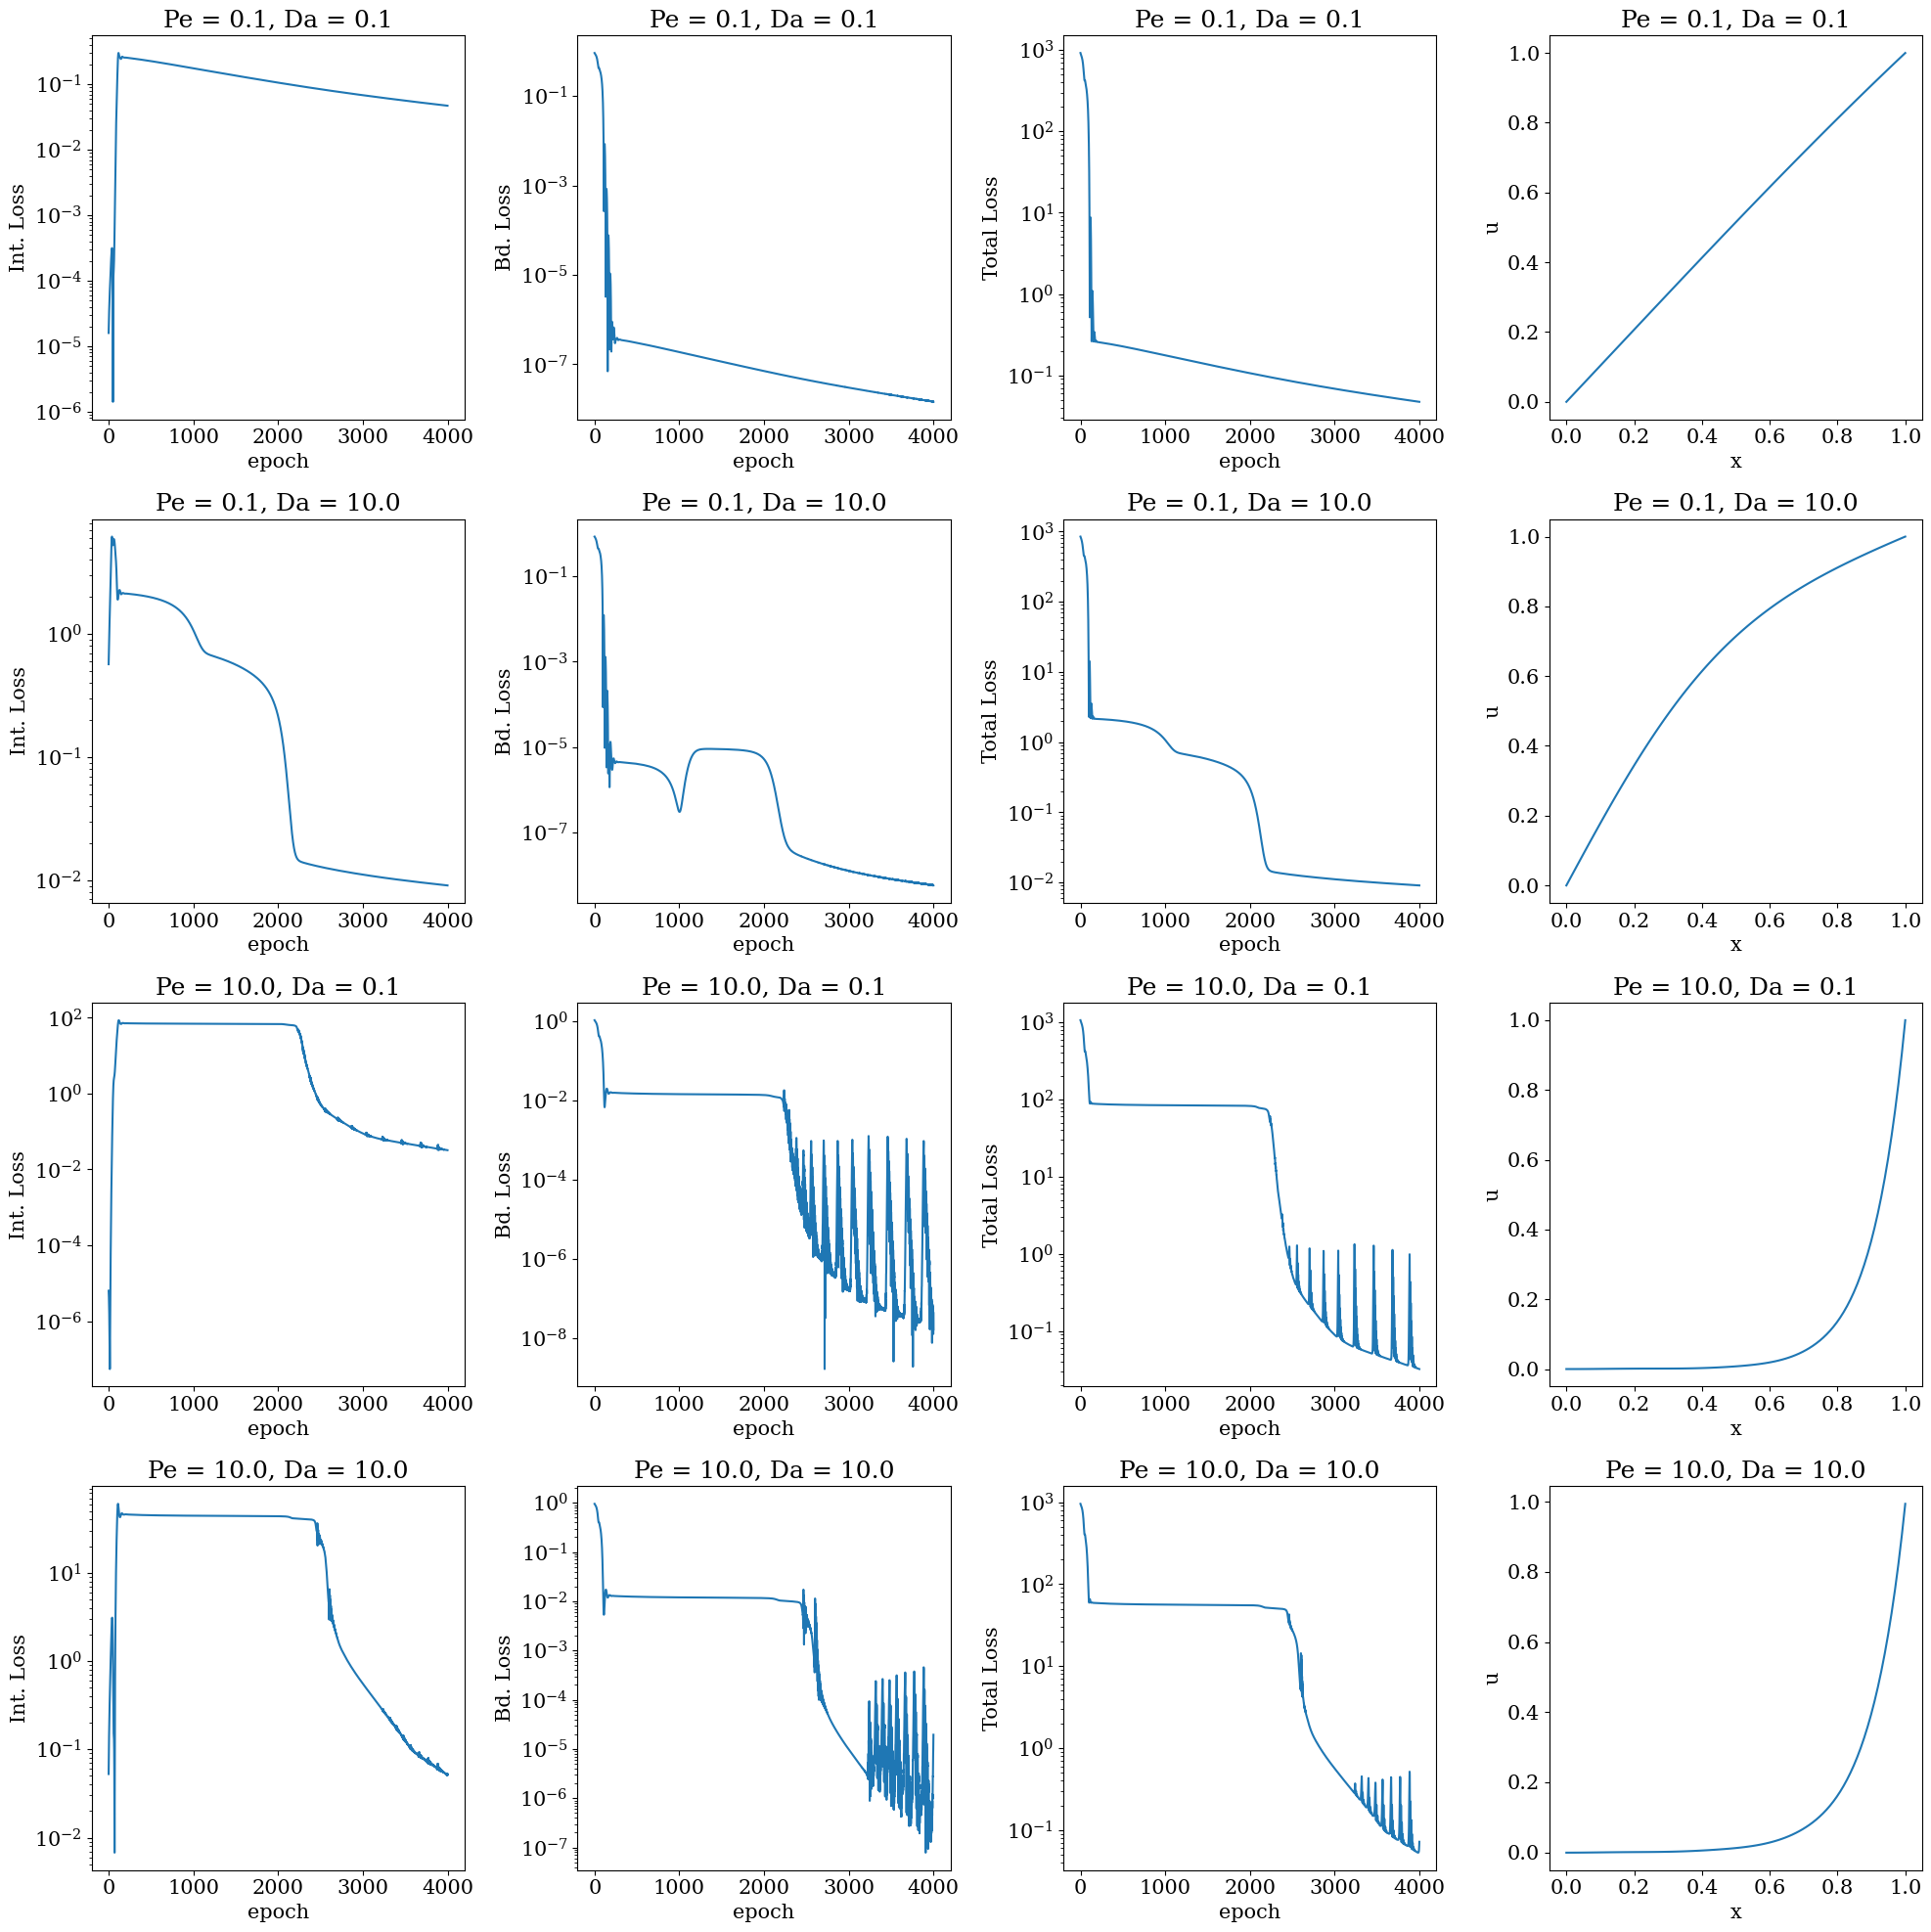

In [9]:
nrows    = len(Pe_list)*len(Da_list)
fig, ax  = plt.subplots(nrows,4,figsize=(5*4,5*nrows))
ax = ax.flatten()
ax_ind = 0
for key in best_run:
    key_full = key + (best_run[key],)

    ax[ax_ind].semilogy(int_loss_dict[key_full],'-')
    ax[ax_ind].set_xlabel('epoch')
    ax[ax_ind].set_ylabel('Int. Loss')
    ax[ax_ind].set_title(f'Pe = {key[0]}, Da = {key[1]}')
    ax_ind+=1

    ax[ax_ind].semilogy(bnd_loss_dict[key_full],'-')
    ax[ax_ind].set_xlabel('epoch')
    ax[ax_ind].set_ylabel('Bd. Loss')
    ax[ax_ind].set_title(f'Pe = {key[0]}, Da = {key[1]}')
    ax_ind+=1

    ax[ax_ind].semilogy(total_loss_dict[key_full],'-')
    ax[ax_ind].set_xlabel('epoch')
    ax[ax_ind].set_ylabel('Total Loss')
    ax[ax_ind].set_title(f'Pe = {key[0]}, Da = {key[1]}')
    ax_ind+=1

    ax[ax_ind].plot(x,pred_dict[key_full],'-')
    ax[ax_ind].set_xlabel('x')
    ax[ax_ind].set_ylabel('u')
    ax[ax_ind].set_title(f'Pe = {key[0]}, Da = {key[1]}')
    ax_ind+=1
#fig.tight_layout()